In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import sklearn
from scipy.stats import shapiro
pd.set_option('display.max_rows', 500)
import warnings; warnings.simplefilter('ignore')
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import random

# 1. IMPORT

In [2]:
path = r'/Users/bryanleavelle/DATA PROJECTS/TATANIC_SPACESHIP/DATA/'

In [3]:
path2 = r'/Users/bryanleavelle/DATA PROJECTS/'

In [4]:
df_train = pd.read_csv(os.path.join(path, 'train.csv'))

In [5]:
df_test = pd.read_csv(os.path.join(path, 'test.csv'))

### I want to be able to manipulate the test and train data at the same time so that I dont have to go back and do everything over to the test set when I am ready to run my model. So first I am going to add an indicator coloumn that keeps track of what is training data and what is test data, then merge the tables together.

In [6]:
# add column in test data
df_test["Type"] = 'Test'

In [7]:
# add column it train data
df_train['Type'] = 'Train'

In [8]:
#concat columns
df_train = pd.concat([df_test, df_train], ignore_index=True)

# 2. POKIN' AROUND

In [9]:
df_train['RoomService'].describe()


count    12707.000000
mean       222.897852
std        647.596664
min          0.000000
25%          0.000000
50%          0.000000
75%         49.000000
max      14327.000000
Name: RoomService, dtype: float64

In [10]:
df_train['ShoppingMall'].describe()

count    12664.000000
mean       174.906033
std        590.558690
min          0.000000
25%          0.000000
50%          0.000000
75%         29.000000
max      23492.000000
Name: ShoppingMall, dtype: float64

In [11]:

sns.set(rc = {'figure.figsize':(10,6)})


In [12]:
# do cryo people get transported more often or less?

crosstab1= pd.crosstab(df_train['CryoSleep'], df_train['Transported'], dropna = False)

In [13]:
crosstab1

Transported,False,True
CryoSleep,,
False,3650,1789
True,554,2483


Most of Those not in cryo were not transported<br>
Most of Those who were in cryo were transported

In [14]:
# any relationship between HomePlanet and Transport?

crosstab2= pd.crosstab(df_train['HomePlanet'], df_train['Transported'], dropna = False)

In [15]:
crosstab2

Transported,False,True
HomePlanet,,
Earth,2651,1951
Europa,727,1404
Mars,839,920


Hard to tell...

In [16]:
# any relationship between destination and transported?

crosstab3= pd.crosstab(df_train['Destination'], df_train['Transported'], dropna = False)

In [17]:
crosstab3

Transported,False,True
Destination,,
55 Cancri e,702,1098
PSO J318.5-22,395,401
TRAPPIST-1e,3128,2787


In [18]:
# VIPs vs transported

crosstab5= pd.crosstab(df_train['VIP'], df_train['Transported'], dropna = False)
crosstab5

Transported,False,True
VIP,,
False,4093,4198
True,123,76


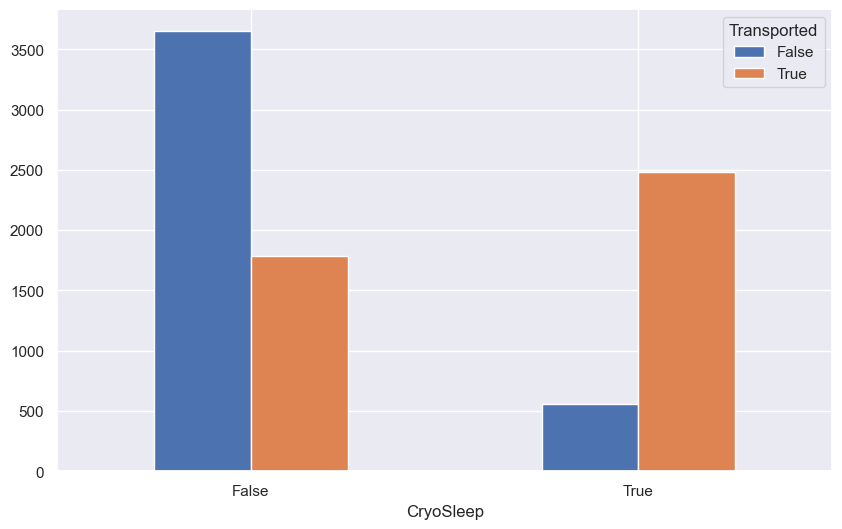

In [19]:
barplot = crosstab1.plot.bar(rot=0)

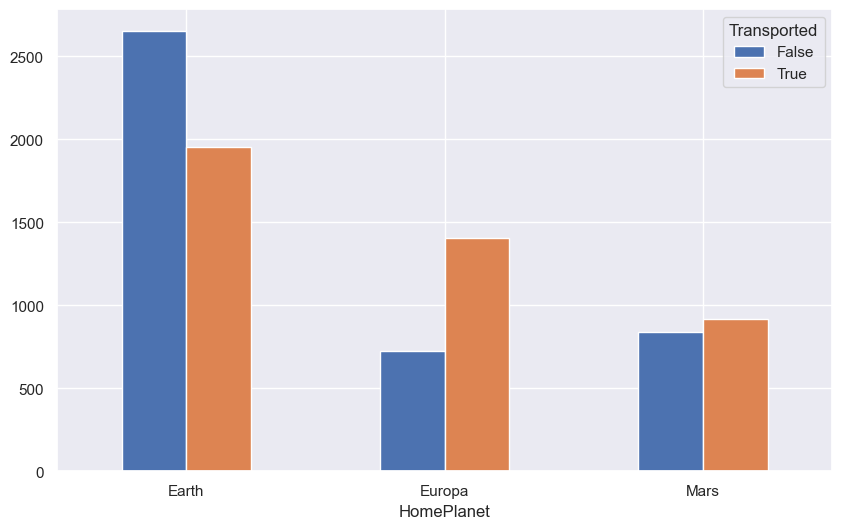

In [20]:
barplot2 = crosstab2.plot.bar(rot=0)

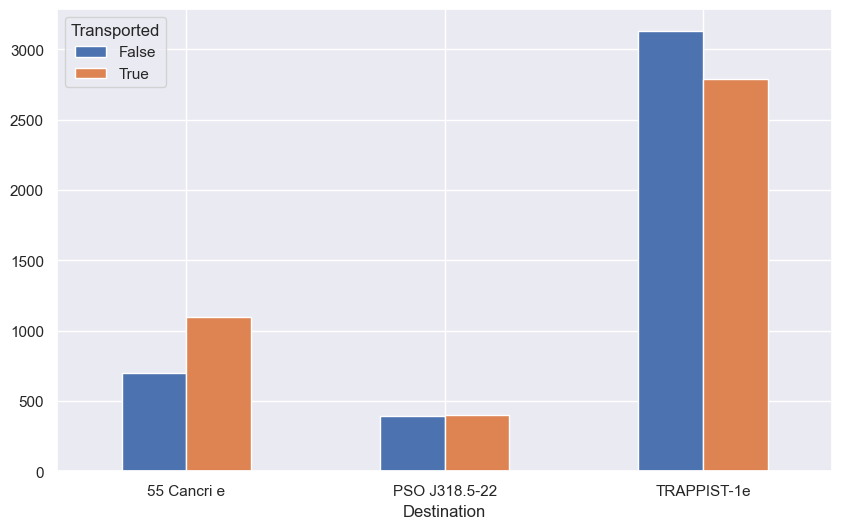

In [21]:
barplot3 = crosstab3.plot.bar(rot=0)

# 3. WRANGLE AND CLEAN

home planet = 1. earth, 2.europa, 3.mars (CHECK) <br>
destination = 1.trappist1, 2.cancri, 3.PSO (CHECK)<br>
vip = 1.true, 0.false (CHECK)<br>
cryo = 1.tru, 0.false (CHECK) <br>
transported = 1.true, 0.false (CHECK)<br>

In [22]:
# Change cryosleep to 1 and 0's

df_train.loc[df_train['CryoSleep'] == True, 'CryoSleep'] = 1
df_train.loc[df_train['CryoSleep'] == False, 'CryoSleep'] = 0

In [23]:
# Change transported to 1's and 0's

df_train.loc[df_train['Transported'] == True, 'Transported'] = 1
df_train.loc[df_train['Transported'] == False, 'Transported'] = 0

In [24]:
# Change HomePPlanet to numerical

df_train.loc[df_train['HomePlanet'] == 'Earth', 'HomePlanet'] = 1
df_train.loc[df_train['HomePlanet'] == 'Europa', 'HomePlanet'] = 2
df_train.loc[df_train['HomePlanet'] == 'Mars', 'HomePlanet'] = 3

In [25]:
# Change VIP to numerical

df_train.loc[df_train['VIP'] == True, 'VIP'] = 1
df_train.loc[df_train['VIP'] == False, 'VIP'] = 0

In [26]:
# change destination to numerical

df_train.loc[df_train['Destination'] == 'TRAPPIST-1e', 'Destination'] = 1
df_train.loc[df_train['Destination'] == '55 Cancri e', 'Destination'] = 2
df_train.loc[df_train['Destination'] == 'PSO J318.5-22', 'Destination'] = 3

In [27]:
# split cabin so deck and side of ship can be analyzed sperately

cabin_split = df_train['Cabin'].str.split('/', expand=True)

In [28]:
cabin_split

,0,1,2
0,G,3,S
1,F,4,S
2,C,0,S
3,C,1,S
4,F,5,S
...,...,...,...
12965,A,98,P
12966,G,1499,S
12967,G,1500,S
12968,E,608,S


In [29]:
# join new split cabin columns back into main data set

df2 = df_train.join(cabin_split)

In [30]:
# rename new cabin columns

df2 = df2.rename(columns={0: 'Deck', 1 : 'Number', 2 : 'Side'})

In [31]:
# delete names

del df_train['Name']

In [32]:
crosstab6 = pd.crosstab(df2['Side'], df2['Transported'])

In [33]:
crosstab6

Transported,0,1
Side,,
P,2308,1898
S,1908,2380


### interesting... larger proportion of Starboard side transported than Port

In [34]:
# port = 1, Side = 2

df2.loc[df2['Side'] == 'P', 'Side'] = 1
df2.loc[df2['Side'] == 'S', 'Side'] = 2

In [35]:
df2.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Type,Transported,Deck,Number,Side
0,0013_01,1,1,G/3/S,1,27.0,0,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,Test,NaN,G,3,2
1,0018_01,1,0,F/4/S,1,19.0,0,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,Test,NaN,F,4,2
2,0019_01,2,1,C/0/S,2,31.0,0,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,Test,NaN,C,0,2
3,0021_01,2,0,C/1/S,1,38.0,0,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter,Test,NaN,C,1,2
4,0023_01,1,0,F/5/S,1,20.0,0,10.0,0.0,635.0,0.0,0.0,Brence Harperez,Test,NaN,F,5,2


In [36]:
crosstab7 = pd.crosstab(df2['Deck'], df2['Transported'])

In [37]:
crosstab7

Transported,0,1
Deck,,
A,129,127
B,207,572
C,239,508
D,271,207
E,563,313
F,1565,1229
G,1238,1321
T,4,1


In [38]:
# delete original cabin column

del df2['Cabin']

In [39]:
df2.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Type,Transported,Deck,Number,Side
0,0013_01,1,1,1,27.0,0,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,Test,NaN,G,3,2
1,0018_01,1,0,1,19.0,0,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,Test,NaN,F,4,2
2,0019_01,2,1,2,31.0,0,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,Test,NaN,C,0,2
3,0021_01,2,0,1,38.0,0,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter,Test,NaN,C,1,2
4,0023_01,1,0,1,20.0,0,10.0,0.0,635.0,0.0,0.0,Brence Harperez,Test,NaN,F,5,2


## now we can finally look at nulls, geez

In [40]:
df2.isnull().sum()

PassengerId        0
HomePlanet       288
CryoSleep        310
Destination      274
Age              270
VIP              296
RoomService      263
FoodCourt        289
ShoppingMall     306
Spa              284
VRDeck           268
Name             294
Type               0
Transported     4277
Deck             299
Number           299
Side             299
dtype: int64

# WOOF

In [41]:
crosstab8 = pd.crosstab(df2['VIP'], df2['Deck'])

### assumption 1: room service, food court, spa, VR Deck, CryoSleep and shopping mall NaNs are meant to be 0. Im going to impute those values now.

In [42]:
df2['RoomService'] = df2['RoomService'].fillna(0)

In [43]:
df2['FoodCourt'] = df2['FoodCourt'].fillna(0)

In [44]:
df2['ShoppingMall'] = df2['ShoppingMall'].fillna(0)

In [45]:
df2['Spa'] = df2['Spa'].fillna(0)

In [46]:
df2['VRDeck'] = df2['VRDeck'].fillna(0)

In [47]:
df2['VIP'] = df2['VIP'].fillna(0)

In [48]:
df2['CryoSleep'] = df2['CryoSleep'].fillna(0)

In [49]:
df2.isnull().sum()

PassengerId        0
HomePlanet       288
CryoSleep          0
Destination      274
Age              270
VIP                0
RoomService        0
FoodCourt          0
ShoppingMall       0
Spa                0
VRDeck             0
Name             294
Type               0
Transported     4277
Deck             299
Number           299
Side             299
dtype: int64

# i overlooked the family status column earlier. I want to split out the ID from the fam status so that we can use that as well.

In [50]:
#  split passenger id from fam status
fam_split = df_train['PassengerId'].str.split('_', expand=True)

In [51]:
fam_split

,0,1
0,0013,01
1,0018,01
2,0019,01
3,0021,01
4,0023,01
...,...,...
12965,9276,01
12966,9278,01
12967,9279,01
12968,9280,01


In [52]:
# join new fam status into main DF

df2 = df2.join(fam_split)

In [86]:
#delete additional passenger id

del df2[0]

In [91]:
df2 = df2.rename(columns={1: 'Fam_status'})

In [92]:
df2

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Type,Transported,Deck,Number,Side,Fam_status
0,0013_01,1,1,1,27.0,0,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,Test,NaN,G,3,2,01
1,0018_01,1,0,1,19.0,0,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,Test,NaN,F,4,2,01
2,0019_01,2,1,2,31.0,0,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,Test,NaN,C,0,2,01
3,0021_01,2,0,1,38.0,0,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter,Test,NaN,C,1,2,01
4,0023_01,1,0,1,20.0,0,10.0,0.0,635.0,0.0,0.0,Brence Harperez,Test,NaN,F,5,2,01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,9276_01,2,0,2,41.0,1,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,Train,0,A,98,1,01
12966,9278_01,1,1,3,18.0,0,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,Train,0,G,1499,2,01
12967,9279_01,1,0,1,26.0,0,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,Train,1,G,1500,2,01
12968,9280_01,2,0,2,32.0,0,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,Train,0,E,608,2,01


In [95]:
# new reorganized DF

df4 = df2[['PassengerId','Deck','Number','Side', 'CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Transported', 'Type', 'Fam_status']]

# OK back to nulls

In [57]:
df4.isnull().sum()

PassengerId        0
Deck             299
Number           299
Side             299
CryoSleep          0
Age              270
VIP                0
RoomService        0
FoodCourt          0
ShoppingMall       0
Spa                0
VRDeck             0
Transported     4277
Type               0
dtype: int64

In [58]:
# AGE description

df4['Age'].describe()

count    12700.000000
mean        28.771969
std         14.387261
min          0.000000
25%         19.000000
50%         27.000000
75%         38.000000
max         79.000000
Name: Age, dtype: float64

In [61]:
df4['VIP'].value_counts()

0    12697
1      273
Name: VIP, dtype: int64

In [62]:
crosstab9 = pd.crosstab(df4['Transported'], df4['Side'])

In [63]:
crosstab9

Side,1,2
Transported,,
0,2308,1908
1,1898,2380


In [64]:
df4.isnull().sum()

PassengerId        0
Deck             299
Number           299
Side             299
CryoSleep          0
Age              270
VIP                0
RoomService        0
FoodCourt          0
ShoppingMall       0
Spa                0
VRDeck             0
Transported     4277
Type               0
dtype: int64

In [65]:
df4['Deck'].value_counts()

F    4239
G    3781
E    1323
B    1141
C    1102
D     720
A     354
T      11
Name: Deck, dtype: int64

In [104]:
# instead of imputing Age with the average, lets impute with a random sample from the values already present in the data set.


df4['Age'] = df4['Age'].fillna(pd.Series(np.random.choice(df4['Age'], size=len(df4.index))))

In [105]:
# instead of imputing Side with the average, lets impute with a random sample from the values already present in the data set.


df4['Side'] = df4['Side'].fillna(pd.Series(np.random.choice(df4['Side'], size=len(df4.index))))

In [107]:
# instead of imputing Deck with the average, lets impute with a random sample from the values already present in the data set.


df4['Deck'] = df4['Deck'].fillna(pd.Series(np.random.choice(df4['Deck'], size=len(df4.index))))

In [108]:
df4.isnull().sum()

PassengerId        0
Deck               0
Number           299
Side               0
CryoSleep          0
Age                0
VIP                0
RoomService        0
FoodCourt          0
ShoppingMall       0
Spa                0
VRDeck             0
Transported     4277
Type               0
Fam_status         0
dtype: int64

In [71]:
df4

,PassengerId,Deck,Number,Side,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Type
0,0013_01,G,3,2.0,1,27.0,0,0.0,0.0,0.0,0.0,0.0,NaN,Test
1,0018_01,F,4,2.0,0,19.0,0,0.0,9.0,0.0,2823.0,0.0,NaN,Test
2,0019_01,C,0,2.0,1,31.0,0,0.0,0.0,0.0,0.0,0.0,NaN,Test
3,0021_01,C,1,2.0,0,38.0,0,0.0,6652.0,0.0,181.0,585.0,NaN,Test
4,0023_01,F,5,2.0,0,20.0,0,10.0,0.0,635.0,0.0,0.0,NaN,Test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,9276_01,A,98,1.0,0,41.0,1,0.0,6819.0,0.0,1643.0,74.0,0,Train
12966,9278_01,G,1499,2.0,1,18.0,0,0.0,0.0,0.0,0.0,0.0,0,Train
12967,9279_01,G,1500,2.0,0,26.0,0,0.0,0.0,1872.0,1.0,0.0,1,Train
12968,9280_01,E,608,2.0,0,32.0,0,0.0,1049.0,0.0,353.0,3235.0,0,Train


In [72]:
df4

,PassengerId,Deck,Number,Side,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Type
0,0013_01,G,3,2.0,1,27.0,0,0.0,0.0,0.0,0.0,0.0,NaN,Test
1,0018_01,F,4,2.0,0,19.0,0,0.0,9.0,0.0,2823.0,0.0,NaN,Test
2,0019_01,C,0,2.0,1,31.0,0,0.0,0.0,0.0,0.0,0.0,NaN,Test
3,0021_01,C,1,2.0,0,38.0,0,0.0,6652.0,0.0,181.0,585.0,NaN,Test
4,0023_01,F,5,2.0,0,20.0,0,10.0,0.0,635.0,0.0,0.0,NaN,Test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,9276_01,A,98,1.0,0,41.0,1,0.0,6819.0,0.0,1643.0,74.0,0,Train
12966,9278_01,G,1499,2.0,1,18.0,0,0.0,0.0,0.0,0.0,0.0,0,Train
12967,9279_01,G,1500,2.0,0,26.0,0,0.0,0.0,1872.0,1.0,0.0,1,Train
12968,9280_01,E,608,2.0,0,32.0,0,0.0,1049.0,0.0,353.0,3235.0,0,Train


In [109]:
df4.isnull().sum()

PassengerId        0
Deck               0
Number           299
Side               0
CryoSleep          0
Age                0
VIP                0
RoomService        0
FoodCourt          0
ShoppingMall       0
Spa                0
VRDeck             0
Transported     4277
Type               0
Fam_status         0
dtype: int64

In [110]:
df_test2 = df4[df4['Type'] == 'Test']

In [111]:
df_train2 = df4[df4['Type'] == 'Train']

In [112]:
df_test2['Type'].value_counts()

Test    4277
Name: Type, dtype: int64

In [113]:
df_train2['Type'].value_counts()

Train    8693
Name: Type, dtype: int64

In [114]:
df_train.shape

(12970, 14)

In [115]:
y = df_train2["Transported"].astype('int')

features = ['PassengerId', 'FoodCourt', "ShoppingMall", "CryoSleep",'Age', 'RoomService', 'Spa', 'VRDeck', 'Side']
X = df_train2[features]


X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=100)

forest = RandomForestClassifier(n_estimators=100, random_state=100)

In [119]:
y.shape

(8693,)

In [120]:
X.shape

(8693, 9)

In [121]:
X.isnull().sum()

PassengerId     0
FoodCourt       0
ShoppingMall    0
CryoSleep       0
Age             0
RoomService     0
Spa             0
VRDeck          0
Side            0
dtype: int64

In [122]:
forest.fit(X_train,y_train)
predictions = forest.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, predictions))

Accuracy: 0.7641871165644172


# off to a decent start!

In [ ]:
y = df_train2["Transported"].astype('int')

features = ['PassengerId', 'FoodCourt', "ShoppingMall", "CryoSleep",'Age', 'RoomService', 'Spa', 'VRDeck', 'Side']
X = df_train2[features]
X_test = df_test2[features]

model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model.fit(X, y)
predictions = model.predict(X_test)

output = pd.DataFrame({'PassengerId': df_test2.PassengerId, 'Transported': predictions})

#have to convert output back to True and False
output.loc[output['Transported'] == 0, 'Transported'] = False
output.loc[output['Transported'] == 1, 'Transported'] = True

output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

# this returned a score of 0.79yadayadayada. Nice.